### Importación de Librerias

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import seaborn as sns
import tensorflow as tf
import toolbox_ML as tb
import warnings

warnings.filterwarnings('ignore')

# Configurar pandas para que no cortar las visualizaciones
pd.set_option("display.max_columns", None)  # Mostrar todas las columnas
pd.set_option("display.max_colwidth", None)  # Mostrar todo el contenido de las celdas, si es posible
# pd.set_option('display.max_rows', None) # Mostrar todas las filas

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras_tuner import HyperModel, Hyperband

### Creando el dataframe

In [23]:
df = pd.read_csv("../data/F1_act.csv")

### Creando Position_Group

In [24]:
# Convertir Position_Order en Position_Group categorizando las posiciones 
def categoriza_posiciones(pos):
    if pos in range(1, 4):
        return 1
    elif pos in range(4, 7):
        return 2
    elif pos in range(7, 10):
        return 3
    elif pos in range(10, 15):
        return 4
    else:
        return 5
df['Position_Group'] = df['Position_Order'].apply(categoriza_posiciones)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6839 entries, 0 to 6838
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Race                      6839 non-null   object 
 1   Driver                    6839 non-null   object 
 2   Constructor               6839 non-null   object 
 3   Circuit                   6839 non-null   object 
 4   Grid                      6839 non-null   int64  
 5   Position_Order            6839 non-null   int64  
 6   Points                    6839 non-null   float64
 7   Laps                      6839 non-null   int64  
 8   Fastest_Lap               6839 non-null   int64  
 9   Rank                      6839 non-null   int64  
 10  Fastest_Lap_Time (Seg)    6839 non-null   float64
 11  Fastest_Lap_Speed (KM/H)  6839 non-null   float64
 12  Status                    6839 non-null   object 
 13  Year                      6839 non-null   int64  
 14  Date    

In [26]:
df.columns

Index(['Race', 'Driver', 'Constructor', 'Circuit', 'Grid', 'Position_Order',
       'Points', 'Laps', 'Fastest_Lap', 'Rank', 'Fastest_Lap_Time (Seg)',
       'Fastest_Lap_Speed (KM/H)', 'Status', 'Year', 'Date', 'Position_Group'],
      dtype='object')

In [27]:
#Eliminar la columa Position_Order porque el grupo la representa
df.drop(columns=['Position_Order'], inplace=True)

### Correlación entre variables

In [28]:
# Ver las nuevas correlaciones considerando el cambio de target
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
correlation_matrix

,Grid,Points,Laps,Fastest_Lap,Rank,Fastest_Lap_Time (Seg),Fastest_Lap_Speed (KM/H),Year,Position_Group
Grid,1.000000,-0.597760,-0.103469,-0.057111,0.547656,0.036675,-0.075956,-0.096786,0.627395
Points,-0.597760,1.000000,0.248350,0.232005,-0.538678,0.066728,0.164408,0.132322,-0.863624
Laps,-0.103469,0.248350,1.000000,0.810019,-0.073243,0.254694,0.504651,0.054212,-0.397154
Fastest_Lap,-0.057111,0.232005,0.810019,1.000000,-0.091930,0.210149,0.455977,0.101223,-0.317099
Rank,0.547656,-0.538678,-0.073243,-0.091930,1.000000,0.369899,0.225351,-0.058957,0.594504
Fastest_Lap_Time (Seg),0.036675,0.066728,0.254694,0.210149,0.369899,1.000000,0.690914,-0.070338,-0.108988
Fastest_Lap_Speed (KM/H),-0.075956,0.164408,0.504651,0.455977,0.225351,0.690914,1.000000,0.088232,-0.244444
Year,-0.096786,0.132322,0.054212,0.101223,-0.058957,-0.070338,0.088232,1.000000,-0.043607
Position_Group,0.627395,-0.863624,-0.397154,-0.317099,0.594504,-0.108988,-0.244444,-0.043607,1.000000


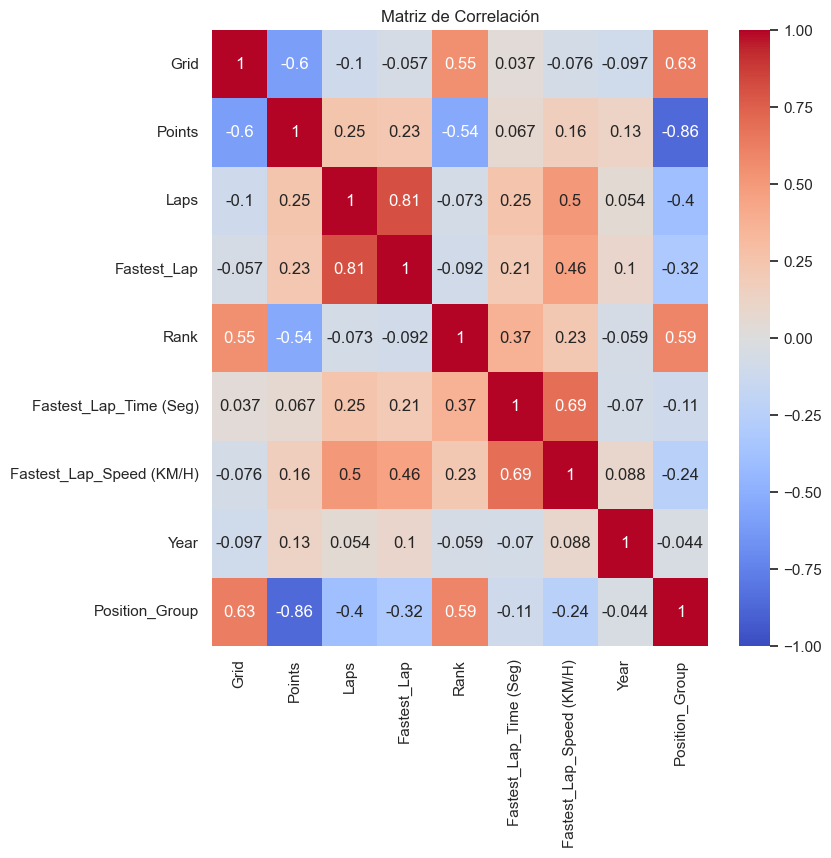

In [29]:
# Configurar el tema a utilizar
sns.set_theme(style="white")

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 8))

# Crear un mapa de calor de la matriz de correlación
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Configurar el título y las etiquetas de los ejes
plt.title('Matriz de Correlación')
plt.show()

In [30]:
# Eliminar las columnas debido a que son datos que no se conocen al momento de iniciar la carrera
df.drop(columns=['Points', "Fastest_Lap", "Fastest_Lap_Time (Seg)","Fastest_Lap_Speed (KM/H)", "Status"], inplace=True)

### Definición de Target

In [31]:
# Definir nuestro target
target_col = "Position_Group"
# Separar las características y el target
X = df.drop(columns=[target_col], axis=1) 
y = df[target_col] 

### Train/Validation/Test Split

In [32]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Obtención de Features Categoricas

In [33]:
cat_feature = tb.get_features_cat_classification(df, target_col)
cat_feature

['Race', 'Driver', 'Constructor', 'Circuit', 'Date']

### Obtención de Features Númericas

In [34]:
num_feature = tb.get_features_num_classification(df,target_col)
num_feature

['Grid', 'Laps', 'Rank', 'Year']

### Baseline Dummy Classifier

In [35]:
# Baseline DummyClassifier para comparar con nuestro modelo
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)
print(f'Baseline DummyClassifier Accuracy: {dummy_accuracy}')

Baseline DummyClassifier Accuracy: 0.34941520467836257


In [36]:
# Identificar las columnas categóricas y numéricas
categorical_features = cat_feature
numeric_features = num_feature

# Preprocesamiento de características numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocesar los datos
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convertir a formato denso si es necesario
X_train_processed = X_train_processed.toarray()
X_test_processed = X_test_processed.toarray()

# Redimensionar los datos para que sean compatibles con Conv1D
X_train_processed = X_train_processed.reshape(X_train_processed.shape[0], X_train_processed.shape[1], 1)
X_test_processed = X_test_processed.reshape(X_test_processed.shape[0], X_test_processed.shape[1], 1)

# Convertir las etiquetas a categóricas
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Crear el modelo de la red neuronal
model = Sequential()

# Capas convolucionales
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_processed.shape[1], 1)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Aplanar los datos
model.add(Flatten())

# Capas densas
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar EarlyStopping y ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(X_train_processed, y_train_categorical, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_test_processed, y_test_categorical),
                    callbacks=[early_stop, model_checkpoint])

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.3229 - loss: 1.9679 - val_accuracy: 0.2412 - val_loss: 1.7544
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.5299 - loss: 1.2067 - val_accuracy: 0.2412 - val_loss: 1.7660
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.5580 - loss: 1.0862 - val_accuracy: 0.3304 - val_loss: 1.5223
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.5891 - loss: 1.0338 - val_accuracy: 0.4518 - val_loss: 1.2389
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.5994 - loss: 0.9762 - val_accuracy: 0.5439 - val_loss: 1.0416
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.6022 - loss: 0.9269 - val_accuracy: 0.5651 - val_loss: 1.0094
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.6299 - loss: 0.8894 - val_accuracy: 0.5746 - val_loss: 0.9959
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6367 - loss: 0.8655 -

In [37]:
# Cargar el modelo previamente guardado
model = load_model('best_model.keras')

# Compilar el modelo cargado
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_continued.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Continuar entrenando el modelo
history = model.fit(X_train_processed, y_train_categorical, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_test_processed, y_test_categorical),
                    callbacks=[early_stop, model_checkpoint, reduce_lr])

# Evaluar el modelo después del entrenamiento adicional
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.6241 - loss: 0.9097 - val_accuracy: 0.1535 - val_loss: 65.1311 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.6367 - loss: 0.9044 - val_accuracy: 0.5724 - val_loss: 1.0177 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.6258 - loss: 0.8603 - val_accuracy: 0.5402 - val_loss: 1.8420 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6518 - loss: 0.8337 - val_accuracy: 0.5687 - val_loss: 1.0203 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6616 - loss: 0.7888 - val_accuracy: 0.5614 - val_loss: 1.0212 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.6972 - loss: 0.7531 - val_accuracy: 0.5541 - val_loss: 1.0887 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.6951 -

In [38]:
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                        activation='relu', input_shape=(X_train_processed.shape[1],)))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(y_train_categorical.shape[1], activation='softmax'))
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model

hypermodel = MyHyperModel()

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='f1_hyperparam_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_tuned.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

tuner.search(X_train_processed, y_train_categorical, 
             epochs=50, 
             validation_data=(X_test_processed, y_test_categorical), 
             callbacks=[early_stop, model_checkpoint, reduce_lr])

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(X_train_processed, y_train_categorical, 
                         epochs=50, batch_size=32, 
                         validation_data=(X_test_processed, y_test_categorical),
                         callbacks=[early_stop, model_checkpoint, reduce_lr])

# Evaluar el modelo
test_loss, test_accuracy = best_model.evaluate(X_test_processed, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')


Reloading Tuner from my_dir\f1_hyperparam_tuning\tuner0.json
Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2588 - loss: 1.6972 - val_accuracy: 0.4715 - val_loss: 1.6378 - learning_rate: 1.0000e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4415 - loss: 1.3904 - val_accuracy: 0.5066 - val_loss: 1.4161 - learning_rate: 1.0000e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4765 - loss: 1.2644 - val_accuracy: 0.5278 - val_loss: 1.2182 - learning_rate: 1.0000e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4905 - loss: 1.2023 - val_accuracy: 0.5424 - val_loss: 1.1108 - learning_rate: 1.0000e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5162 - loss: 1.1538 - val_accuracy: 0.5541 - val_loss: 1.0589 - learning_rate: 1.0000e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5137 - loss: 1.1215 - val_accuracy: 0.5702 - val_loss: 1.0305 - learning_rate: 1.0000e-04
Epo